# Replication of Ramey and Zubairy (2018)* 


In this notebook, we will replicate the results of Ramey and Zubairy (2018)* using Python. The authors study the effects of government spending on output using historical data from the United States. They employ state-dependent local projections to estimate the government spending multiplier in both good and bad economic states.


*Ramey, V. A., & Zubairy, S. (2018). Government spending multipliers in good times and in bad: evidence from US historical data. Journal of political economy, 126(2), 850-901.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import datetime

## Data

Ramey and Zubairy (2018) use quarterly data from 1899 to 2015. Their historical series include real GDP, the GDP deflator, government purchases, federal government receipts, population, the unemployment rate, interest rates, and defense news shocks.


The shocks series contains news about defense spending and is constructed using narrative identification. „This news series focuses on changes in government spending that are linked to political and military events since these changes are most likely to be independent of the state of the economy.“ (Ramey und Zubairy 2018, p. 857)

In [2]:
data_description = pd.read_excel('data/RZDAT.xlsx', sheet_name='readme', skiprows=7, header=None)
data_description.columns = ['Variable', 'Description']
data_description

,Variable,Description
0,ngov,nominal government purchases
1,ngdp,nominal GDP
2,pgdp,GDP implicit price deflator
3,pop,"total population, including armed forces overseas"
4,recession,recession indicator
5,unemp,civilian unemployment rate
6,news,military news
7,rgdp,real GDP
8,nfedcurrreceipts_nipa,"nominal Federal current receipts, NIPA accrual..."
9,ndeficit_nipa,"nominal deficit, NIPA accrual basis, construct..."


In [3]:
raw = pd.read_excel('data/RZDAT.xlsx', sheet_name='rzdat')

# Extract year and quarter
quarters = raw['quarter']
years = quarters.astype(int)
quarters_num = ((quarters - years) * 4 + 1).astype(int)

# Combine to "YYYYQn" format
period_str = years.astype(str) + 'Q' + quarters_num.astype(str)
# Convert to Period (quarterly)
periods = pd.PeriodIndex(period_str, freq='Q')
# If you want a datetime (start of quarter)
dates = periods.to_timestamp()

raw.index = dates

raw.head()

,quarter,ngov,ngdp,pgdp,pop,recession,unemp,news,rgdp,nfedcurrreceipts_nipa,...,ngdp_altcr,ntotrev_nipa,pubfeddebt_treas,fedrevq_treas,fedexpq_treas,nfedexp_nipa,hpunemp_split,hpunemp_full,tbill_interp,nydiscrate
quarter,,,,,,,,,,,,,,,,,,,,,
1875-01-01,1875.00,NaN,NaN,NaN,45049.082031,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1875-04-01,1875.25,NaN,NaN,NaN,45314.832031,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1875-07-01,1875.50,NaN,NaN,NaN,45572.582031,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1875-10-01,1875.75,NaN,NaN,NaN,45814.332031,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1876-01-01,1876.00,NaN,NaN,NaN,46056.082031,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


You will need the following variables:
- `ngdp`: Nominal GDP
- `ngov`: Nominal government spending
- `pgdp`: GDP deflator
- `news`: News shocks
- `rgdp_pott6`: Potential GDP 
- `unemp`: Unemployment rate

In [4]:
data = raw.copy()
select_cols = ['ngdp', 'ngov', 'pgdp', 'news', 'rgdp_pott6', 'unemp']
data = data[select_cols]
data.head()

,ngdp,ngov,pgdp,news,rgdp_pott6,unemp
quarter,,,,,,
1875-01-01,NaN,NaN,NaN,NaN,NaN,NaN
1875-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1875-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1875-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1876-01-01,NaN,NaN,NaN,NaN,NaN,NaN


Data transformations:
- Start at 1899Q1
- End at 2015Q4
- Create real variables by dividing by the GDP deflator (pgdp) for:
  - Nominal GDP (ngdp)
  - News shocks (news)
  - Nominal government spending (ngov)
- Normalize the following variables by potential GDP (rgdp_pott6):
  - Real GDP (rgdp)
  - Real government spending (rgov)
  - Real news shocks (news)


In [5]:
start = datetime.datetime(1899,1,1)
end = datetime.datetime(2015,1,1)

# Select the data between start and end dates
data = data[(data.index >= start) & (data.index <= end)]

# Create real series
data['rgdp'] = data['ngdp'] / data['pgdp']
data['rgov'] = data['ngov'] / data['pgdp']
data['rnews'] = data['news'] / data['pgdp']
# Normalizations
data['y'] = data['rgdp'] / data['rgdp_pott6']
data['g'] = data['rgov'] / data['rgdp_pott6']
data['newsy'] = data['rnews'] / data['rgdp_pott6']

data.head()

,ngdp,ngov,pgdp,news,rgdp_pott6,unemp,rgdp,rgov,rnews,y,g,newsy
quarter,,,,,,,,,,,,
1899-01-01,17.841935,1.276110,0.045240,0.106,403.1978,6.3248,394.3858,28.207684,2.343070,0.978145,0.069960,0.005811
1899-04-01,18.140834,1.299786,0.045656,0.000,406.6220,5.5871,397.3356,28.468992,0.000000,0.977162,0.070013,0.000000
1899-07-01,18.986121,1.179927,0.046664,0.000,410.0508,5.9812,406.8687,25.285595,0.000000,0.992240,0.061665,0.000000
1899-10-01,19.780050,1.215081,0.047961,0.000,413.4845,5.5070,412.4229,25.334983,0.000000,0.997433,0.061272,0.000000
1900-01-01,19.682206,1.149512,0.048154,0.090,416.9237,5.1656,408.7329,23.871480,1.868996,0.980354,0.057256,0.004483


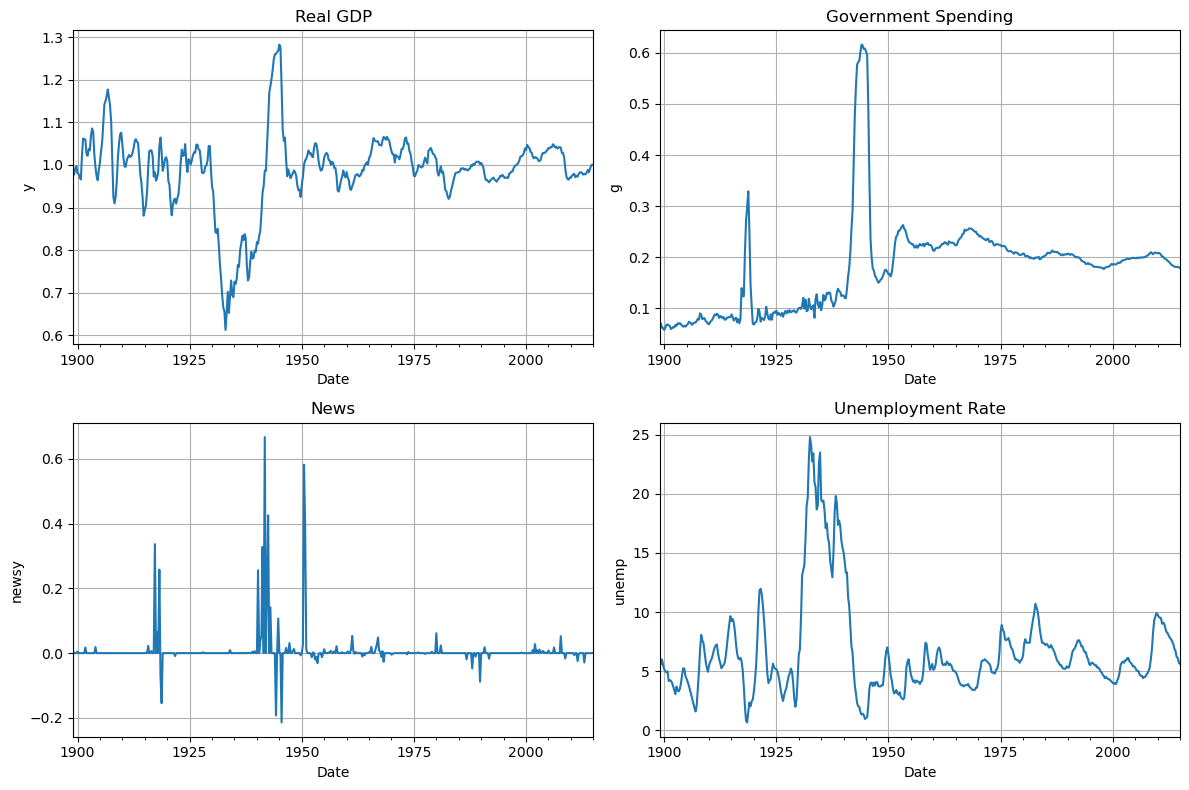

In [6]:
plot_vars = ['y', 'g', 'newsy', 'unemp']
labels = ['Real GDP', 'Government Spending', 'News', 'Unemployment Rate']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i, var in enumerate(plot_vars):
    ax = axes[i // 2, i % 2]
    data[var].plot(ax=ax)
    ax.set_title(labels[i])
    ax.set_xlabel('Date')
    ax.set_ylabel(var)
    ax.grid()
fig.tight_layout()

## Local Projections

The formula for the linear Local Projections is given by:
$$
x_{t+h} = \alpha_h + \beta_h \text{shock}_{t} + \gamma_h Z_{t-1} + \epsilon_{t+h}
$$

„The baseline shock is the defense news variable scaled by trend GDP. Our vector of baseline control variables, z, contains real per capita GDP and government spending, each divided by trend GDP. In addition, z includes lags of the news variable to control for any serial correlation in the news variable.“ (Ramey und Zubairy, 2014, p. 862)

Set the number of lags to 4 and the number of horizons to 20. The authors use a Newey-West correction with a lag length of 4 for the standard errors.

In [7]:
n_lags = 4
var_to_lag = ['y', 'g', 'newsy']
controls = []
# Create lags
for var in var_to_lag:
    for lag in range(1, n_lags + 1):
        var_lag = f'{var}_lag{lag}'
        data[var_lag] = data[var].shift(lag)
        controls.append(var_lag)

formula_y = "y_lead ~ newsy + " + " + ".join(controls)
formula_g = "g_lead ~ newsy + " + " + ".join(controls)

print(formula_y)
print(formula_g)


y_lead ~ newsy + y_lag1 + y_lag2 + y_lag3 + y_lag4 + g_lag1 + g_lag2 + g_lag3 + g_lag4 + newsy_lag1 + newsy_lag2 + newsy_lag3 + newsy_lag4
g_lead ~ newsy + y_lag1 + y_lag2 + y_lag3 + y_lag4 + g_lag1 + g_lag2 + g_lag3 + g_lag4 + newsy_lag1 + newsy_lag2 + newsy_lag3 + newsy_lag4


In [8]:
horizons = 20
# Init containers for thetas and standard errors
thetas = {"y": np.empty(horizons), "g": np.empty(horizons)}
standard_errors = {"y": np.empty(horizons), "g": np.empty(horizons)}

# Run LP 
for h in range(0,horizons):
    data_h = data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['y_lead'] = data_h['y'].shift(-h)
    data_h['g_lead'] = data_h['g'].shift(-h)

    # Model for Industrial Production
    model_y = sm.formula.ols(formula=formula_y, data=data_h)
    results_y = model_y.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['y'][h] = results_y.params['newsy']
    standard_errors['y'][h] = results_y.bse['newsy']

    # Model for Inflation
    model_g = sm.formula.ols(formula=formula_g, data=data_h)
    results_g = model_g.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['g'][h] = results_g.params['newsy']
    standard_errors['g'][h] = results_g.bse['newsy']


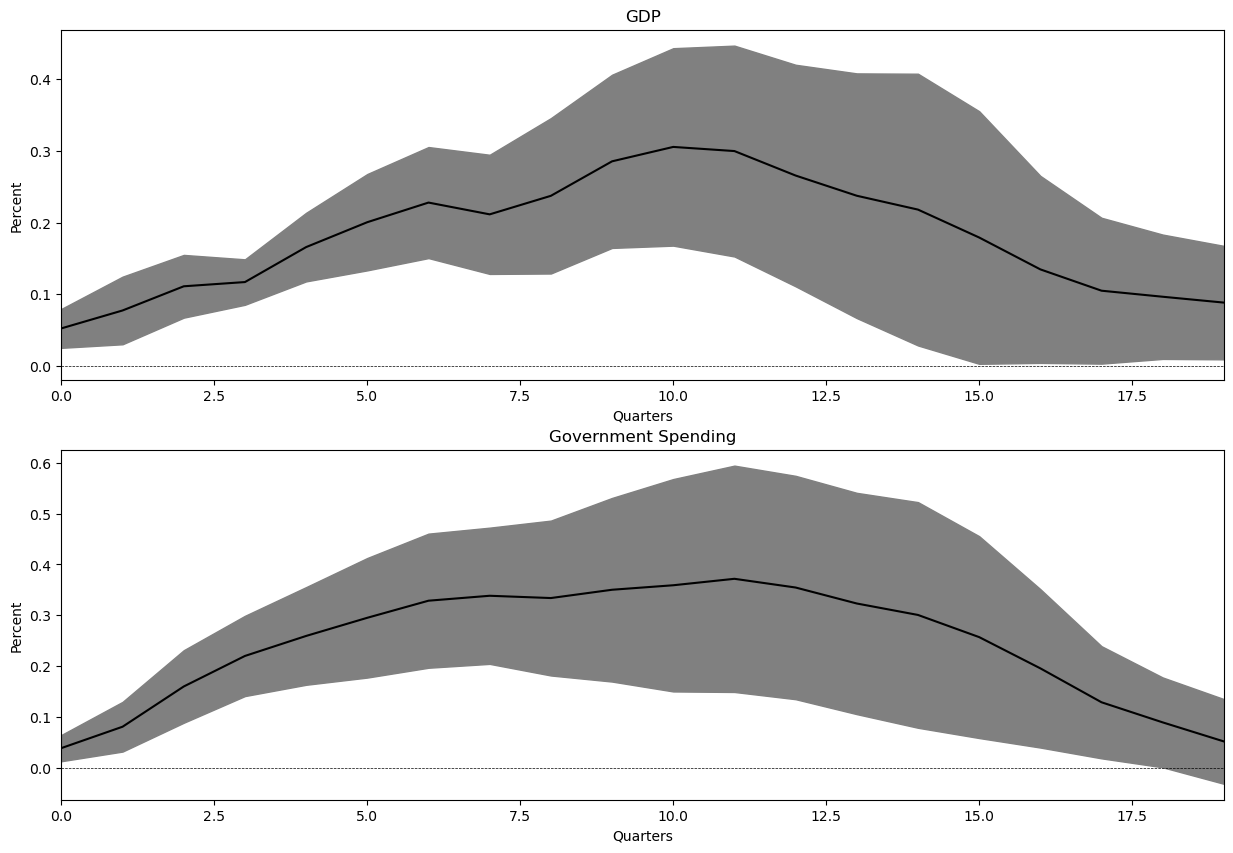

In [9]:
# Response of government spending and GDP to a news shock equal to 1 percent of GDP.
fig, axs = plt.subplots(2, 1, figsize=(15, 10))
titles = ['GDP', 'Government Spending']
# Plot the results
for i, var in enumerate(['y', 'g']):
    axs[i].plot(np.arange(len(thetas[var])), thetas[var], color='black')
    axs[i].fill_between(np.arange(horizons), thetas[var] - 1.645 *  standard_errors[var], thetas[var] + 1.645 *  standard_errors[var], color='grey')
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Quarters')
    axs[i].set_ylabel('Percent')
    axs[i].set_xlim(0, horizons-1)
    axs[i].axhline(0, color='black', linewidth=0.5, linestyle='--')

plt.show()

## State Dependent Local Projections

Now we will estimate the state-dependent local projections. The authors use a dummy variable for periods of slack (slack) and a dummy variable for periods of boom (boom). The formula for the state-dependent local projections is given by:
$$
y_t = I_{t-1} [\alpha_{a,h} + \beta_{a,h} \text{shock}_t + \gamma_{a,h} Z_{t-1}] + (1 - I_{t-1}) [\alpha_{b,h} + \beta_{b,h} \text{shock}_t + \gamma_{b,h} Z_{t-1}] + \epsilon_t
$$

where I is a dummy variable that indicates the state of the economy when the shock hits.


You will need to create additional variables for the state-dependent local projections:
- `slack`: Dummy variable for periods of slack (unemployment rate > 6.5%)
- `boom`: Dummy variable for periods of boom (unemployment rate < 6.5%)
- Variables for the state-dependent local projections that you get by multiplying the original variables with the dummy variable:
  - Real normalized GDP in periods of slack
  - Real normalized GDP in periods of boom
  - Real normalized government spending in periods of slack
  - Real normalized government spending in periods of boom
  - Real normalized news shocks in periods of slack
  - Real normalized news shocks in periods of boom

In [10]:
data['slack'] = data['unemp'] > 6.5
data['boom'] = data['unemp'] <= 6.5

vars_to_interact = ['y', 'g', 'newsy']
# Create interaction terms
for var in vars_to_interact:
    data[f'{var}_slack'] = data[var] * data['slack']
    data[f'{var}_boom'] = data[var] * data['boom']

# Create lags
vars_to_lag = vars_to_interact
controls = []
for var in vars_to_lag:
    for lag in range(1, n_lags + 1):
        var_lag_boom = f'{var}_boom_lag{lag}'
        var_lag_slack = f'{var}_slack_lag{lag}'
        data[var_lag_boom] = data[var].shift(lag)
        data[var_lag_slack] = data[var].shift(lag)
        controls.append(var_lag_boom)
        controls.append(var_lag_slack)

formula_y = "y_lead ~ newsy_slack + newsy_boom + " + " + ".join(controls)
formula_g = "g_lead ~ newsy_slack + newsy_boom + " + " + ".join(controls)

print(formula_y)
print(formula_g)

y_lead ~ newsy_slack + newsy_boom + y_boom_lag1 + y_slack_lag1 + y_boom_lag2 + y_slack_lag2 + y_boom_lag3 + y_slack_lag3 + y_boom_lag4 + y_slack_lag4 + g_boom_lag1 + g_slack_lag1 + g_boom_lag2 + g_slack_lag2 + g_boom_lag3 + g_slack_lag3 + g_boom_lag4 + g_slack_lag4 + newsy_boom_lag1 + newsy_slack_lag1 + newsy_boom_lag2 + newsy_slack_lag2 + newsy_boom_lag3 + newsy_slack_lag3 + newsy_boom_lag4 + newsy_slack_lag4
g_lead ~ newsy_slack + newsy_boom + y_boom_lag1 + y_slack_lag1 + y_boom_lag2 + y_slack_lag2 + y_boom_lag3 + y_slack_lag3 + y_boom_lag4 + y_slack_lag4 + g_boom_lag1 + g_slack_lag1 + g_boom_lag2 + g_slack_lag2 + g_boom_lag3 + g_slack_lag3 + g_boom_lag4 + g_slack_lag4 + newsy_boom_lag1 + newsy_slack_lag1 + newsy_boom_lag2 + newsy_slack_lag2 + newsy_boom_lag3 + newsy_slack_lag3 + newsy_boom_lag4 + newsy_slack_lag4


In [11]:
horizons = 20
# Init containers for thetas and standard errors
thetas = {"y_slack": np.empty(horizons), "y_boom": np.empty(horizons), "g_slack": np.empty(horizons), "g_boom": np.empty(horizons)}
standard_errors = {"y_slack": np.empty(horizons), "y_boom": np.empty(horizons), "g_slack": np.empty(horizons), "g_boom": np.empty(horizons)}

# Run LP 
for h in range(0,horizons):
    data_h = data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['y_lead'] = data_h['y'].shift(-h)
    data_h['g_lead'] = data_h['g'].shift(-h)

    # Model for Industrial Production
    model_y = sm.formula.ols(formula=formula_y, data=data_h)
    results_y = model_y.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['y_slack'][h] = results_y.params['newsy_slack']
    thetas['y_boom'][h] = results_y.params['newsy_boom']
    standard_errors['y_slack'][h] = results_y.bse['newsy_slack']
    standard_errors['y_boom'][h] = results_y.bse['newsy_boom']

    # Model for Inflation
    model_g = sm.formula.ols(formula=formula_g, data=data_h)
    results_g = model_g.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['g_slack'][h] = results_g.params['newsy_slack']
    thetas['g_boom'][h] = results_g.params['newsy_boom']
    standard_errors['g_slack'][h] = results_g.bse['newsy_slack']
    standard_errors['g_boom'][h] = results_g.bse['newsy_boom']


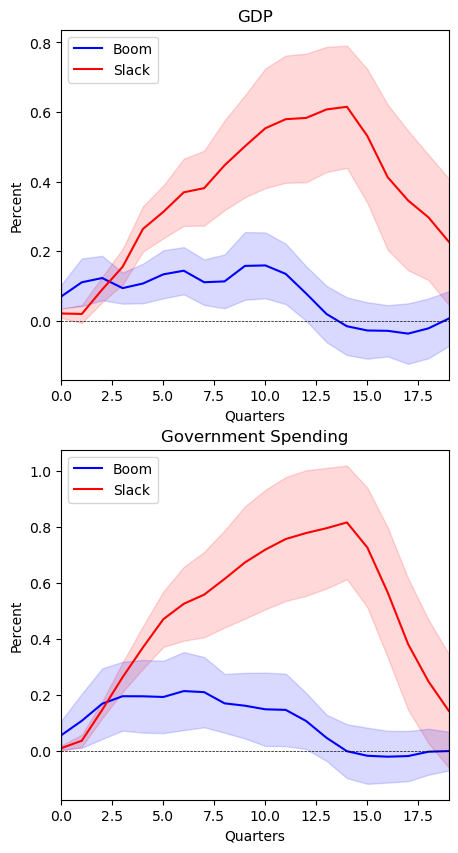

In [12]:
# Response of government spending and GDP to a news shock equal to 1 percent of GDP.
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
titles = ['GDP', 'Government Spending']
# Plot the results
for i, var in enumerate(['y', 'g']):
    var_boom = f'{var}_boom'
    var_slack = f'{var}_slack'
    axs[i].plot(np.arange(len(thetas[var_boom])), thetas[var_boom], color='blue', label='Boom')
    axs[i].plot(np.arange(len(thetas[var_slack])), thetas[var_slack], color='red', label='Slack')
    axs[i].fill_between(np.arange(horizons), thetas[var_slack] - 1.645 *  standard_errors[var_slack], thetas[var_slack] + 1.645 *  standard_errors[var_slack], color="red", alpha=.15)
    axs[i].fill_between(np.arange(horizons), thetas[var_boom] - 1.645 *  standard_errors[var_boom], thetas[var_boom] + 1.645 *  standard_errors[var_boom], color="blue", alpha=.15)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Quarters')
    axs[i].set_ylabel('Percent')
    axs[i].set_xlim(0, horizons-1)
    axs[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axs[i].legend()

plt.show()

## State-dependent Local Projections using regime proababilities

In [13]:
# create column for output growth in past 4 quarters
data['rgdp_growth'] = data['rgdp'].pct_change(periods=4) * 100
data['rgdp_growth_demeaned'] = data['rgdp_growth'] - data['rgdp_growth'].mean()
# apply transition function
def transition_function(x, gamma):
    return np.exp(-gamma * x) / (1 + np.exp(-gamma * x))

High slack periods: 23.44%, Boom periods: 22.58%


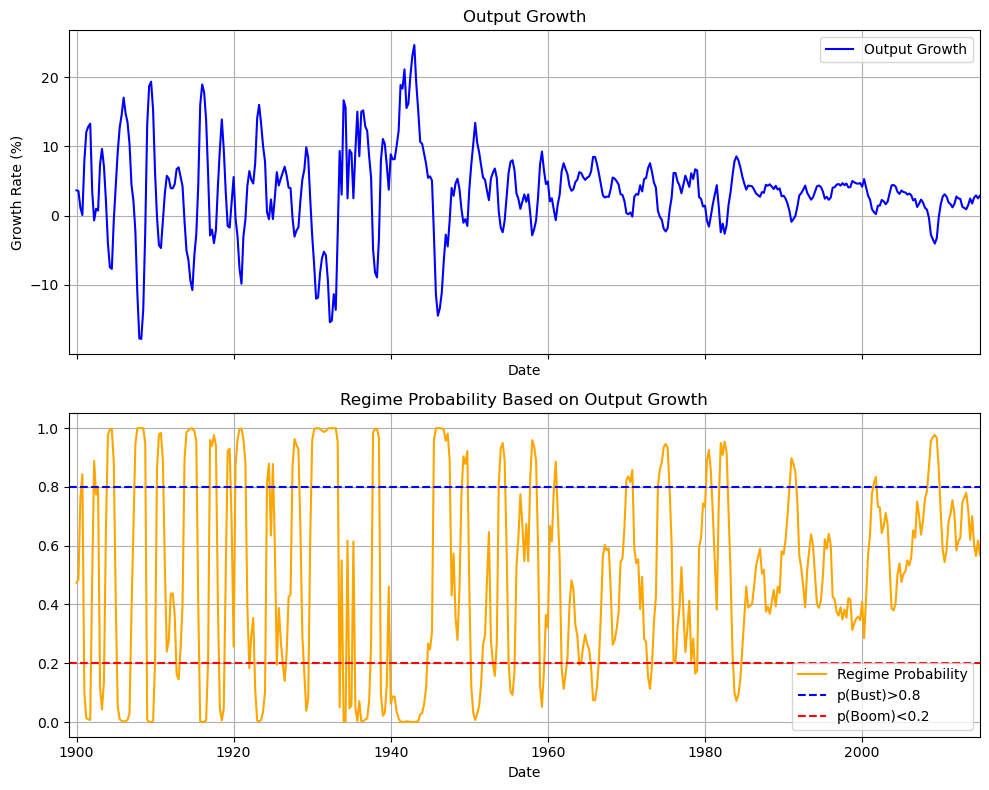

In [14]:
regime_prob = transition_function(data['rgdp_growth_demeaned'], 0.5)
slack = np.mean([regime_prob > 0.8]) 
boom = np.mean([regime_prob < 0.2])
print(f"High slack periods: {slack:.2%}, Boom periods: {boom:.2%}")
# plot regime probabilties in one plot and output growth underneath
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Output growth plot
axs[0].plot(data.index, data['rgdp_growth'], label='Output Growth', color='blue')
axs[0].set_title('Output Growth')
axs[0].set_ylabel('Growth Rate (%)')

axs[1].plot(data.index, regime_prob, label='Regime Probability', color='orange')
axs[1].axhline(0.8, color='blue', linestyle='--', label='p(Bust)>0.8')
axs[1].axhline(0.2, color='red', linestyle='--', label='p(Boom)<0.2')
axs[1].set_title('Regime Probability Based on Output Growth')

for ax in axs:
    ax.set_xlabel('Date')
    ax.legend()
    ax.grid()
    ax.set_xlim(data.index.min(), data.index.max())
plt.tight_layout()

plt.show()

In [15]:
data['slack_prob'] = transition_function(data['rgdp_growth_demeaned'], 0.5)
data['boom_prob'] = 1 - data['slack_prob']

vars_to_interact = ['y', 'g', 'newsy']
# Create interaction terms
for var in vars_to_interact:
    data[f'{var}_slack'] = data[var] * data['slack_prob']
    data[f'{var}_boom'] = data[var] * data['boom_prob']

# Create lags
vars_to_lag = vars_to_interact
controls = []
for var in vars_to_lag:
    for lag in range(1, n_lags + 1):
        var_lag_boom = f'{var}_boom_lag{lag}'
        var_lag_slack = f'{var}_slack_lag{lag}'
        data[var_lag_boom] = data[var].shift(lag)
        data[var_lag_slack] = data[var].shift(lag)
        controls.append(var_lag_boom)
        controls.append(var_lag_slack)

formula_y = "y_lead ~ newsy_slack + newsy_boom + " + " + ".join(controls)
formula_g = "g_lead ~ newsy_slack + newsy_boom + " + " + ".join(controls)

print(formula_y)
print(formula_g)

y_lead ~ newsy_slack + newsy_boom + y_boom_lag1 + y_slack_lag1 + y_boom_lag2 + y_slack_lag2 + y_boom_lag3 + y_slack_lag3 + y_boom_lag4 + y_slack_lag4 + g_boom_lag1 + g_slack_lag1 + g_boom_lag2 + g_slack_lag2 + g_boom_lag3 + g_slack_lag3 + g_boom_lag4 + g_slack_lag4 + newsy_boom_lag1 + newsy_slack_lag1 + newsy_boom_lag2 + newsy_slack_lag2 + newsy_boom_lag3 + newsy_slack_lag3 + newsy_boom_lag4 + newsy_slack_lag4
g_lead ~ newsy_slack + newsy_boom + y_boom_lag1 + y_slack_lag1 + y_boom_lag2 + y_slack_lag2 + y_boom_lag3 + y_slack_lag3 + y_boom_lag4 + y_slack_lag4 + g_boom_lag1 + g_slack_lag1 + g_boom_lag2 + g_slack_lag2 + g_boom_lag3 + g_slack_lag3 + g_boom_lag4 + g_slack_lag4 + newsy_boom_lag1 + newsy_slack_lag1 + newsy_boom_lag2 + newsy_slack_lag2 + newsy_boom_lag3 + newsy_slack_lag3 + newsy_boom_lag4 + newsy_slack_lag4


In [16]:
horizons = 20
# Init containers for thetas and standard errors
thetas = {"y_slack": np.empty(horizons), "y_boom": np.empty(horizons), "g_slack": np.empty(horizons), "g_boom": np.empty(horizons)}
standard_errors = {"y_slack": np.empty(horizons), "y_boom": np.empty(horizons), "g_slack": np.empty(horizons), "g_boom": np.empty(horizons)}

# Run LP 
for h in range(0,horizons):
    data_h = data.copy()
    # shift the dependent variable by h periods and drop resulting na observations 
    data_h['y_lead'] = data_h['y'].shift(-h)
    data_h['g_lead'] = data_h['g'].shift(-h)

    # Model for Industrial Production
    model_y = sm.formula.ols(formula=formula_y, data=data_h)
    results_y = model_y.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['y_slack'][h] = results_y.params['newsy_slack']
    thetas['y_boom'][h] = results_y.params['newsy_boom']
    standard_errors['y_slack'][h] = results_y.bse['newsy_slack']
    standard_errors['y_boom'][h] = results_y.bse['newsy_boom']

    # Model for Inflation
    model_g = sm.formula.ols(formula=formula_g, data=data_h)
    results_g = model_g.fit(cov_type='HAC', cov_kwds={'maxlags':24})
    thetas['g_slack'][h] = results_g.params['newsy_slack']
    thetas['g_boom'][h] = results_g.params['newsy_boom']
    standard_errors['g_slack'][h] = results_g.bse['newsy_slack']
    standard_errors['g_boom'][h] = results_g.bse['newsy_boom']


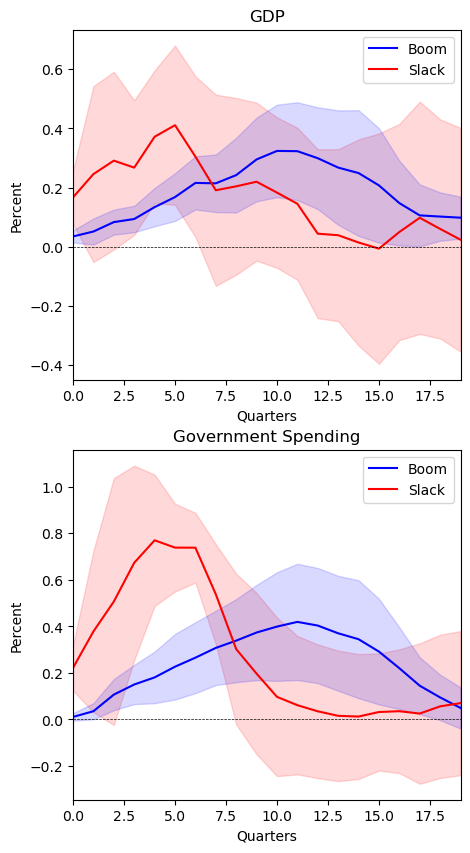

In [17]:
# Response of government spending and GDP to a news shock equal to 1 percent of GDP.
fig, axs = plt.subplots(2, 1, figsize=(5, 10))
titles = ['GDP', 'Government Spending']
# Plot the results
for i, var in enumerate(['y', 'g']):
    var_boom = f'{var}_boom'
    var_slack = f'{var}_slack'
    axs[i].plot(np.arange(len(thetas[var_boom])), thetas[var_boom], color='blue', label='Boom')
    axs[i].plot(np.arange(len(thetas[var_slack])), thetas[var_slack], color='red', label='Slack')
    axs[i].fill_between(np.arange(horizons), thetas[var_slack] - 1.645 *  standard_errors[var_slack], thetas[var_slack] + 1.645 *  standard_errors[var_slack], color="red", alpha=.15)
    axs[i].fill_between(np.arange(horizons), thetas[var_boom] - 1.645 *  standard_errors[var_boom], thetas[var_boom] + 1.645 *  standard_errors[var_boom], color="blue", alpha=.15)
    axs[i].set_title(titles[i])
    axs[i].set_xlabel('Quarters')
    axs[i].set_ylabel('Percent')
    axs[i].set_xlim(0, horizons-1)
    axs[i].axhline(0, color='black', linewidth=0.5, linestyle='--')
    axs[i].legend()

plt.show()